## **Chapter 2 - [Machine Learning Project](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb)**

Crearemos un algoritmo capaz de predecir los precios de las casas en California. Conseguiremos los datos, haremos una breve representación visual que nos de pistas de que marca el precio de una casa, los prepararemos,  crearemos un modelo, y finalmente analizaremos las importancias de cada atributo.

Este capítulo será hecho de manera breve. Al realizarlo hace unos meses no me gustaba usar los notebooks, y por simplicidad, al usar Spyder, una vez hecho el análisis exploratorio, los eliminé para no llenar de imagenes el escritorio. Los interesados pueden revisar el original pinchando arriba.

In [0]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###**1. Conseguir los datos**

Conseguimos los datos en fuentes oficiales, en este caso estarán disponible para el lector en el repositorio. **Son del Censo de 1990**

In [4]:
"""Data"""
data = pd.read_csv("housing.csv")
data.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


Vemos que la cantidad de piezas y dormitorios está en función del distrito. Por tanto para predecir el precio de una casa promedio en dicho distrito tendremos que dividir las columnas: 

- **Piezas por casa**: "total_rooms" con "households" 
- **Dormitorios por casa**: "total_bedrooms" con "households"
- **Gente por casa**: "population" con "households"

In [0]:

data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

###**2. Representación Visual de Datos**

Una buena representación visual siempre es muy útil para guiar la cosntrucción del modelo. Lo haremos en base a precios, ubicación y densidad de poblacional.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[0, 16, 0, 550000]

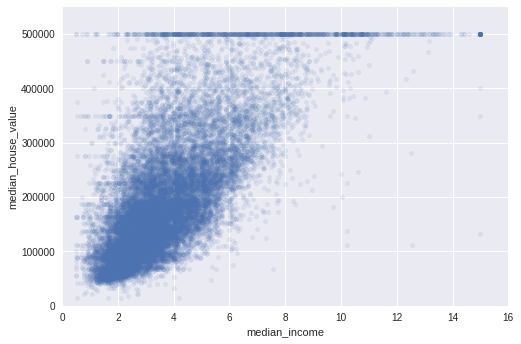

In [38]:
data.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Vemos que existe una relación entre el valor de la casa y el ingreso. Arriba, en la parte superior del gráfico, vemos varios puntos alineados horizontalmente. Esto ocurre porque los precios de casas están truncados con máximo en 500.000 USD, representando 500.000 USD o más.

Es natural que ocurra, dado que gente de mayores ingresos usualmente vive en casas de un mayor valor.

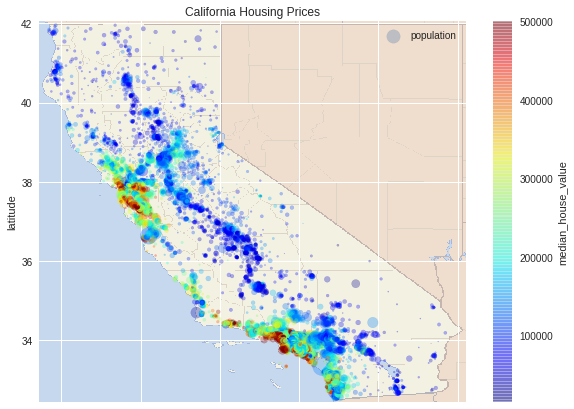

In [6]:
"""Gráfico de Precios de California"""
import matplotlib.image as mpimg
california_img=mpimg.imread("california.png")
california = data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, 
          s=data["population"]/100, label="population", 
          figsize=(10, 7), c="median_house_value", 
          cmap="jet", title="California Housing Prices") # California Housing
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.show()

Lo que más determina el precio de una casa es la cercanía a centros urbanos. Tales como San Francisco o Los Angeles, tambien lo es estar cerca del mar y la densidad poblacional. 

Esto es intuititivo, los centros urbanos destacan por la cantidad de servicios y mejores oportunidades laborales que ofrcen a sus residentes. Además están el hecho de estar cerca del mar, que tradicionalmente es muy valorado. Por último, la densidad poblacional, las ciudades atraen más personas (más atractivas y por tanto más caras), ser más atractivas crea un circulo virtuoso en los precios, ya que la mayor demanda por hogares cerca del centrohace subir los precios

###**3. Manipulación de Datos**

Vemos que al visualizar la primera linea de datos hay variables no numéricas. Para poder ser consideradas en el modelo tienen que ser transformadas, especialmente si son importantes como lo es la cercanía al mar.

In [0]:
"""DataPrep"""
data_num = data.drop("ocean_proximity", axis=1) #Imputer funciona en data numerica, saco tempralmente la no numerica
data_cat = pd.DataFrame(data["ocean_proximity"])
data_cat["ocean_proximity"].value_counts()
numerico = {"<1H OCEAN":0, "INLAND":1, "NEAR OCEAN":8, "NEAR BAY": 9, "ISLAND": 3}
data_cat1 = pd.DataFrame(data_cat["ocean_proximity"].map(numerico))

from sklearn.preprocessing import Imputer #rellenador de nan values
from sklearn.preprocessing import StandardScaler #escalador
from sklearn.pipeline import Pipeline #automatizador
atributos = data.drop(["median_house_value", "ocean_proximity"], axis=1)

Para no tener que hacer este proceso a mano si es que sabemos que en el futuro tendrá que ser repetido, tenemos a nuestra disposición un pipeline. Que lo que hace es hacer pasar por esta **tubería** los datos para que sean transformados e incluso para que pueda ser creado el modelo.

Por ahora solo imputaremos los datos y los escalaremos, porque no usaremos una regresión lineal simple.

In [10]:
#automatizamos preprocesamiento
pipeline_num = Pipeline([
        ("imputer", Imputer(strategy="median")),
        ("scaler", StandardScaler())])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Separamos los datos que compondrán nuestros atributos de nuestra variable dependiente. Así podremos hacer manipulaciones sin la posibilidad de que metamos la pata sobre nuestra variable dependiente (a esta no la queremos escalar).

In [0]:
Xs = pd.DataFrame(pipeline_num.fit_transform(atributos), columns = atributos.columns)
data_cat2 = pd.DataFrame(pipeline_num.fit_transform(data_cat1), columns = data_cat1.columns)
Xs["ocean_proximity"] = data_cat2

In [0]:
"""SelectModel, train it & test it"""
from sklearn.model_selection import train_test_split
y = data["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20)

###**4. Selección de Modelo**

Solo consideraré el modelo ganador, el de RandomForest. Que lo que hace es tomar multiples veces pequeñas muestras de la muestra de entrenamiento y aplica sobre cada una de ellas arboles de decisón. Promediando los resultados y muy frecuentemente mejorando los resultados de la predicción. 

In [0]:
#RandomForest!!
from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(n_estimators=200, n_jobs=200)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

#error
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_test, y_pred3)**0.5 #cambiar de acuerdo a modelo

In [28]:
error

51090.82566817966

####**4.1 Trucos para mejorar el Modelo**

Vemos que el error igual es alto. Son 50.000 dolares en promedio de error. El precio mediano de las casas es de 456.000 dólares aprox.

In [34]:
"""GridSearch, para dejar más efectivo el modelo"""
from sklearn.model_selection import GridSearchCV
param_grid = [
        {"n_estimators": [3, 10, 3], "max_features": [2, 4, 6, 8]},
        {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
        ]
grid_search = GridSearchCV(model3, param_grid, cv=5, 
                           scoring = "neg_mean_squared_error")
grid_search.fit(Xs, y)
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


78896.80928008513 {'max_features': 2, 'n_estimators': 3}
69267.75330922064 {'max_features': 2, 'n_estimators': 10}
79950.24148412484 {'max_features': 2, 'n_estimators': 3}
80698.82269231173 {'max_features': 4, 'n_estimators': 3}
67245.95845137107 {'max_features': 4, 'n_estimators': 10}
78129.2399539605 {'max_features': 4, 'n_estimators': 3}
76018.8849992811 {'max_features': 6, 'n_estimators': 3}
68009.52184130042 {'max_features': 6, 'n_estimators': 10}
76831.08488652915 {'max_features': 6, 'n_estimators': 3}
75115.81203548235 {'max_features': 8, 'n_estimators': 3}
67614.42411634959 {'max_features': 8, 'n_estimators': 10}
76558.59768620148 {'max_features': 8, 'n_estimators': 3}
78757.37379272483 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
70410.74272055716 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
80341.61665272404 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
67341.48321202051 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
7737

**Modelo Ganador**

In [35]:
"""Modelo Seleccionado"""
seleccionado = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

seleccionado.fit(X_train, y_train)
y_pred_seleccionado = seleccionado.predict(X_test)
error = mean_squared_error(y_test, y_pred_seleccionado)**0.5 #cambiar de acuerdo a modelo
error

51978.514513590235

Finalmente podemos analizar la importancia de cada varible. Como vemos, es importante el ingreso del hogar (proxy de barrio, junto con ubicación (5to y 6to lugar)). Cantidad de dormitorios y proximidad con el mar. 

Además tenemos en tercer lugar una inesperada: Habitantes por hogar, es probable su relevancia ya que mayor cantidad de personas viviendo en una casa significa mayor cantidad de espacio necesario y mayor cantidad de personas que pueden aportar en pagar el arriendo o compra de una casa.

In [50]:
"""Explorar importancia de cada atributo"""
feature_importances = grid_search.best_estimator_.feature_importances_
importancia = pd.DataFrame(feature_importances, Xs.columns)
importancia.columns = ["Importancia"]
importancia.sort_values(by="Importancia", ascending=False)

,Importancia
median_income,0.309364
bedrooms_per_room,0.122817
population_per_household,0.107838
ocean_proximity,0.093005
longitude,0.091474
latitude,0.088806
rooms_per_household,0.063048
housing_median_age,0.050527
total_rooms,0.018904
total_bedrooms,0.018560
